# WYZNACZENIE OPTYMALNEJ TRASY FORMUŁY 1 NA ZAKRĘCIE (kąt 90°) 

## WSTĘP

### NA CZYM POLEGA F1?

Formuła 1 jest to cykl prestiżwoych, międzynarodowych wyścigów samochodowych, znany również jako wyścigi Grand Prix. Grand Prix składa się z 3 segmentów:
- sesji treningowych
- kwalifikacji
- wyścigu

Sesje treningowe służą zespołom do sprawdzania bolidów, testowania opon na torze, czy oceny nowych podzespołów.
Ważniejszą częścią są kwalifikacje, które polegają na przejazdach na czas w pojedynkę, co później determinuje pozycję startową kierowcy w wyścigu. Wbrew pozorom, miejsce startowe ma kluczowe znaczenie, ponieważ podczas samego wyścigu kierowcy nie mają zbyt wielu możliwości na wyprzedzanie. Podczas ostatniego segmentu GP wyłaniany jest zwycięzca.

### BUDOWA POJAZDÓW

Ze względu na charakter F1, kluczowe dla zespołów biorących udział w zawodach jest zbudowanie jak najbardziej wydajnego bolidu, który będzie w stanie w możliwie jak najkrótszym czasie pokonać tor. Drużyny w każdym roku wydają setki milionów dolarów, aby osiągnąć ten cel. Największe znaczenie dla osiągów pojazdu mają: silnik (o mocy ok. 1000 KM), elementy aerodynamiczne oraz opony.

### CO BĘDZIEMY BRAĆ POD UWAGĘ W PROJEKCIE?

Celem projektu jest próba wyznaczenia najbardziej optymalnej trasy jaką bolid powinien pokonać na zakręcie o kącie 90 stopni. Zauważając, iż optymalna trasa zawsze będzie najkrótszą krzywą (o czym świadczy między innymi najmniejszy kąt nachylenia, skrętu), szukając najlepszej drogi dla bolidu, wyznaczymy losowe łuki oraz zestawimy ze sobą ich długości tym samym wyznaczając długości danych tras. Ze względu na to, że bardzo dużo różnych czynników wpływa na tor jazdy bolidu, na potrzeby naszego projektu musieliśmy zaniedbać takie czynniki jak: aerodynamika pojazdu, czyli działającego na niego opory powietrza oraz docisk (który sprawia, że przepływające przez aerodynamiczne elementy pojazdu powietrze “dociska” go do ziemi przy rozwijaniu większych prędkości), zużycie opon, warunki pogodowe, itp. Postanowiliśmy także przenieść nasze rozważania na tor 2D (zakładamy, że kierowca porusza się po idealnie równym terenie). Skupimy się na wyznaczeniu najbardziej optymalnej trasy, przy stałej prędkości jazdy, zakładając także, że pojazd pokonując zakręt porusza się po okręgu.

### FIZYKA PRZY RUCHU NA ZAKRĘCIE

Ruch samochodu na zakręcie po torze wyścigowym można opisać za pomocą ruchu krzywoliniowego, który wymaga rozpatrzenia dodatkowych sił działających na samochód w kierunku promienia zakrętu. Przyjmijmy, że samochód porusza się po płaskim torze o promieniu R, a jego prędkość wynosi v.
W przypadku ruchu po okręgu, siła skierowana w kierunku promienia zakrętu (siła odśrodkowa) działa na samochód i jest proporcjonalna do prędkości kwadratowej samochodu. 
\begin{equation*}
F = \frac{mv^2}{R}
\end{equation*}
Siła ta przeciwdziała siłom inercji, które dążą do utrzymania samochodu na trajektorii prostej.
<center>
    <img src="images/siły fizyki1.png" alt="siły_fizyki.png"> <img src="images/siły fizyki2.png" alt="siły_fizyki.png">
</center>


## GENEROWANIE NAJKRÓTSZYCH TRAS

Pierwszym krokiem w naszym projekcie jest wygenerowanie losowych tras możliwych do pokonania na zadanym zakręcie. W tym celu najpierw zostaje zadeklarowany zakręt(1), który będzie ograniczony przez łuki odpowiadające 1/4 okręgu o promieniu 10 oraz 20. Następnie zostają stworzone tablice(2) do których będą odpowiednio dodawane potrzebne dane. Po przygotowaniu miejsca dla wartości sporządzamy funkcję generowanie_tras(3) w której danymi wejściowymi będzie kolejno ograniczenie dolne i górne (promień łuków ograniczających). Funkcja ta losuje 400 losowych wartości, po 200 w tablicy i interuje kolejno po dwóch elementach z czego powstaje 40 000 losowo wygenerowanych tras, które są zadane przybliżeniami kołowymi. W zadanej pętli obliczamy również:
- r - promień wygenerowanego okręgu
- odl - odległość miedzy punktem (0,0), a środkiem danego okregu
- y_0 - punkt przecięcia funkcji z osią OY
- cieciwa - odległość między punktem (15,0) a (0,y_0)
- alfa - kąt tworzony przez punkty: (0,y_0), sr danego okregu i (15,0)
- dl - długość łuku

Jednak ze względu na badany zakręt poprzez odpowiedni warunek odsiewamy wszystkie trasy które "wypadają" z zakrętu bądź ich kąt wyjścia jest zbyt mały w stosunku do dalszej jazdy, czyli bolid nie byłby w stanie kontynuować trasy.

In [30]:
using Distributions
using Plots
using QuadGK
using ForwardDiff
using DataFrames

#(1) DEKLARACJA ZAKRĘTU(trasa ograniczona przez dwa łuki odpowiadające kolejno 1/4 okręgu o ograniczeniu_g/d)
ograniczenie_d = 10 # promien krótszego łuku
ograniczenie_g = 20 # promien dluzszego łuku

f(x) = ograniczenie_g*sin(x)
g(x) = ograniczenie_g*cos(x)
h(x) = ograniczenie_d*sin(x)
j(x) = ograniczenie_d*cos(x)
luk_min = [g, j] #łuk będący minimalnym ograniczeniem trasy
luk_max = [f, h] #łuk będący maksymalnym ograniczeniem trasy

#(2) DEKLARACJA TABLIC ZMIENNYCH
tab_sin = Array{Function}(undef, 0) #równanie okręgu sin
tab_cos = Array{Function}(undef, 0) #równanie okręgu cos
x_wspolrzedne = [] #współrzędne x wygenerowanych okręgów
y_wspolrzedne = [] #współrzedne y wygenerowanych okregów
promienie = [] 
alfy = [] 
dlugosci = [] 

#(3)
function generowanie_tras(ograniczenie_d = 10, ograniczenie_g = 20)
    """
    FUNKCJA: Generuje losowe trasy i oblicza niektóre wartości dla nich 
    INPUT:
        ograniczenie_d (Float) - promień łuku będącego ograniczeniem dolnym trasy
        ograniczenie_g (Float) - promień łuku będącego ograniczeniem górnym trasy
    """
    
    los1 = rand(Uniform(-100, 0), 200)
    los2 = rand(Uniform(-100, 100), 200)
    for x in los1 #współrzędna x wygenerowanego okregu
        for y in los2 #współrzedna y wygenerowanego okregu
            r = sqrt((x-15)^2 + y^2) # promien danego okregu
            odl = sqrt((x)^2 + y^2) # odl miedzy punktem (0,0), a srodkiem danego okregu
            y_0 = y + sqrt(r^2 - x^2) # punkt przeciecia z osia OY (0, y0)
            cieciwa = sqrt(15^2 + y_0^2) # odl miedzy punktem (15,0) a (0,y0)
            if abs(r-ograniczenie_d-0.25) > odl && y_0 < ograniczenie_g-0.25 && r<50 # ograniczenia
                alfa = acos(1-((cieciwa^2)/(2*r^2))) # kąt tworzony przez punkty: (0,y0), sr danego okregu i (15,0) 
                dl = alfa*r  # dlugosc luku okregu miedzy (0,y0) i (15,0)
                push!(x_wspolrzedne, x)
                push!(y_wspolrzedne, y)
                push!(promienie, r)
                push!(alfy, alfa)
                push!(dlugosci, dl)
            end
        end
    end

    for s in 1:length(promienie)
        p(x) = promienie[s]*sin(x) + y_wspolrzedne[s]
        q(x) = promienie[s]*cos(x) + x_wspolrzedne[s]
        push!(tab_sin, p)
        push!(tab_cos, q)
    end
end
generowanie_tras(ograniczenie_d, ograniczenie_g)

## WYGENEROWANIE TRAS NA WYKRESIE

In [31]:
plot(tab_cos, tab_sin, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, 20),
     ylim=(0, 20), legend=false)
plot!(luk_min, luk_max, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## OBLICZANIE DROGI JAKĄ POKONA POJAZD

### WYNIK OCZEKIWANY

Analizując podstawowy wzór fizyczny jakim jest: $\displaystyle s=\int \operatorname{d}s=\int v(t)\operatorname{d}t=\int r(\theta)\operatorname{d}\theta$, jesteśmy w stanie za pomocą badania zmiany kąta w konkretnym punkcie obliczyć optymalną drogę jaką powinien pokonać bolid aby ta była jak najbardziej optymalna. Tutaj dodatkowo posiłkując się spiralą Eulera jesteśmy w stanie wyznaczyć dwa koła będące naszą „trasą”, inaczej mówiąc jej ograniczeniami. 

Jest to o tyle dogodne dla nas narzędzie iż dzięki takiemu przybliżeniu jesteśmy w stanie skorzystać z przekształconego wzoru i zamiast zmian kąta pod jakim pojazd się ustawia do trasy, które musiałyby bazować na dużych tablicach macierzowych za względu na pary punktów, korzystamy ze stałych promieni oraz danego przekształcenia: 
\begin{equation*}
\displaystyle s=\int \sqrt{\left(r_{1}+\left(\frac{r_{2}-r_{1}}{s_{1}}\right)\cdot s\right) \cdot \left(\frac{1}{\mu \cdot g}\right)}\operatorname{d}\!s.
\end{equation*}
Za pomocą tego wzoru zaimplementowanego do Julii sprawdzimy najkrótszą możliwą do pokonania trasę i będzie ona wartością bazową ze względu na jej stałość. 

### FUNKCJA PREZENTUJĄCA ZAKRĘT

In [32]:
function integrand(s::Float64, r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64)
    u = r1 + (r2 - r1) / s1 * s
    sqrt(u/m*g)
end
a = 0.0
b = pi/2
max_order = 1000

1000

### METODA PROSTOKĄTÓW

W tej metodzie korzystamy z definicji całki oznaczonej Riemanna, w której wartość całki interpretowana jest jako suma pól obszarów pod wykresem krzywej w zadanym przedziale całkowania $[x_{p}, x_{k}]$. Następnie sumę tę przybliżamy przy pomocy sumy pól odpowiednio dobranych prostokątów.

Przedział całkowania $[x_{p}, x_{k}]$ dzielimy na $n$ równo odległych punktów $x_{1}, x_{2}, ..., x_{n},$ jak na załączonej grafice.

<center>
    <img src="images/prostokaty.png" alt="metoda_prostokątów.png">
</center>


Następnie obliczamy odległości między prostokątami
\begin{equation*}
\Delta x = \frac{x_{k}-x_{p}}{n}
\end{equation*}
Dla każdego wyznaczonego w ten sposób punktu obliczamy wartość funkcji $f(x).$
Następnie obliczamy sumę iloczynów wyznaczonych wartości funkcji przez odległość $\Delta x$ między dwoma sąsiednimi punktami
\begin{equation*}
S = f_{1}\cdot\Delta x + f_{2}\cdot\Delta x + ... + f_{n}\cdot\Delta x = \Delta x \cdot (f_{1}+f_{2}+...+f_{n})
\end{equation*}

In [33]:
function integrate_rectangles(f, a, b, n)
    delta_x = (b - a) / n
    x_values = a .+ ((0:n-1) .+ 0.5) * delta_x
    f_values = f.(x_values)
    result = delta_x * sum(f_values)
    result
end


P = integrate_rectangles(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.81292342039797

### METODA TRAPEZÓW

Metoda ta jest podobna do poprzedniej z tym, że zamiast prostokątów używamy trapezów o wysokościach $\Delta x$ i podstawach równych odpowiednim wartościom funkcji $f(x)$ w punktach krańcowych.


<center>
    <img src="images\trapezy.png" alt="metoda_trapezów.png">
</center>


In [34]:
function integrate_trapezoids(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64, n::Int64)
    delta_s = (b - a) / n
    s_values = a .+ (0:n-1) * delta_s
    u_values = r1 .+ (r2 - r1) / s1 * s_values
    f_values = integrand.(s_values, r1, r2, s1, m, g)
    result = delta_s * ((integrand(a, r1, r2, s1, m, g) + integrand(b, r1, r2, s1, m, g)) / 2.0 + sum(f_values))
    result
end

T = integrate_trapezoids(10.0, 20.0, 1.0, 1.0, 10.0, a, b, max_order)

20.828630803342858

#### METODA SIMPSONA

Metoda ta jest podobna do poprzednich z tym, że do przybliżenia całki stosujemy parabolę.

<center>
    <img src="images\simpson.jpg" alt="metoda_simpsona.jpg">
</center>


In [35]:
function integrate_simpson(f, a, b, n)
    delta_x = (b - a) / n
    x_values = a .+ (0:n) * delta_x
    f_values = f.(x_values)
    coefficients = ifelse.(iseven.(0:n), 2, 4)
    suma = sum(coefficients .* f_values)
    result = delta_x / 3 * (f(a) + f(b) + suma)
    result
end


S = integrate_simpson(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.840185657012736

#### PRÓBA KONTROLNA (ZA POMOCĄ PAKIETU WBUDOWANEGO QUADGK)

In [36]:
function integrate(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64)
    f(s) = integrand(s, r1, r2, s1, m, g)
    Q, err=quadgk(f, a, b)
    Q, err
end
W = (integrate(10.0, 20.0, 1.0, 1.0, 10.0, a, b))

(20.812923226956958, 2.063025306142663e-10)

#### ZESTAWIENIE TABELARYCZNE OBLICZEŃ DOTYCZĄCYCH DROGI ZE STAŁEGO WZORU (PORÓWNANIE METOD)

In [37]:
tabela = DataFrame(PROSTOKĄTÓW = P, TRAPEZÓW = T, SIMPSONA = S, WBUDOWANA = W[1])
tabela

1×4 DataFrame
 Row │ PROSTOKĄTÓW  TRAPEZÓW  SIMPSONA  WBUDOWANA 
     │ Float64      Float64   Float64   Float64   
─────┼────────────────────────────────────────────
   1 │     20.8129   20.8286   20.8402    20.8129

Analizując poszczególne wyniki możemy zauważyć iż wszystkie oscylują  bliżej, bądź dalej w okolicach wyniku 20.8. W związku z takowym faktem opierając się na powyższym przekształceniu potraktujemy wynik jako długość najbardziej optymalnej trasy i w naszych dalszych obliczeniach będziemy do tej wartości przyrównywać wyniki.

### OBLICZANIE DŁUGOŚCI WYGENEROWANYCH TRAS

#### FUNKCJA RIEMANNA

Suma Riemanna jest jednym z najprostszych do zrozumienia przybliżeń pola powierzchni pod krzywą. Jej podstawową ideą jest to, że przedział [a, b] jest podzielony przez punkty $a=x_{0}<x_{1}<x_{2}<...<x_{n}=b$ i teren pod $f(x)$ jest aproksymowany przez prostokąt z podstawą $x_{i}+1 - x_{i}$ i wysokość podaną jako $f(s)$, gdzie s to jakiś punkt z przedziału $[x_{i}, x_{i+1}]$. Typowe wybory to lewy punkt lub prawy interwału lub wartośi x, która minimalizuje lub maksymalizuje przez interwał. Rysunek przedstawia te cztery opcje dla pewnej przykładowej funkcji. Dla funkcji całkowalnej Riemanna, takiej jak funkcja ciągła na zadanym przedziale, każda z opcji da taką samą wartość, do jakiej zmniejszy się siatka partycji.
<center>
    <img src="images\riemann_choice.png" alt="riemann_choice.png">
</center>


W naszym kodzie zaimplementowaliśmy funkcję do obliczenia całki metodą Riemanna. W omawianym kodzie danymi wejściowymi funkcji będą:
- funkcja,
- wartość początkowa i końcowa interwału oraz
- liczba równych podprzedziałów.

Ponadto dopuszczamy możliwość zastosowania różnych metod aproksymacji obszaru w podprzedziale. Wyróżniamy tu funkcje w których skorzystamy z:
- prostokąta z lewym końcem do określenia wysokości (method="left" )
- prostokąta z prawym końcem do określenia wysokości (method="right" )
- trapezu utworzonego przez połączenie lewego i prawego punktu końcowego (method="trapezoid" )
- wielomianu o stopniu dwa, który przechodzi przez lewy i prawy punkt końcowy oraz punkt środkowy ( method="simpsons")

In [38]:
function riemann(f, a::Real, b::Real, n::Int; metoda="right")
  if metoda == "right"
     m = (f,l,r) -> f(r) * (r-l)
  elseif metoda == "left"
     m = (f,l,r) -> f(l) * (r-l)
  elseif metoda == "trapezoid"
     m = (f,l,r) -> (1/2) * (f(l) + f(r)) * (r-l)
  elseif metoda == "simpsons"
     m = (f,l,r) -> (1/6) * (f(l) + 4*(f((l+r)/2)) + f(r)) * (r-l)
  end

  xs = range(a, b, length=n+1)
  lrs = zip(Iterators.take(xs, n), Iterators.rest(xs, 1))
  sum(m(f, l, r) for (l,r) in lrs)
end

riemann (generic function with 1 method)

#### I SPOSÓB

Pierwszy sposób jaki uwzględnimy w naszym projekcie będzie bazował na wzorze: 
\begin{equation*}
L = 2\pi r \left(\frac{\theta}{360^{\circ}}\right).
\end{equation*}
Zawarty jest on w pętli kodu, gdzie za pomocą twierdzenia cosinusów obliczamy kąt $\theta$. Kąt ten dokładnie jest zobrazowany na poniższym obrazie, na którym również widoczne jest skąd bierzemy konkretne dane w kodzie. 

<center>
    <img src="images\theta.jpg" alt="theta.jpg">
</center>

Wszystkie wartości kąta z tych obliczeń zostają dodane do tablicy dlugosci skąd teraz czerpiemy dane.

In [39]:
print(argmin(dlugosci), "\n") # numer argumentu o najkrotszym luku
print(dlugosci[argmin(dlugosci)])
dlugosci

257
18.959135808453823

719-element Vector{Any}:
 19.481727770278525
 22.499023170390508
 20.411705093839817
 24.25251857916639
 21.725580113354763
 26.80680664528892
 21.138175077201627
 22.687081672765196
 20.41672720850665
 24.18708258507409
 21.80371878301108
 20.846545049306346
 27.90376049359599
  ⋮
 22.20965123591133
 19.19566126774272
 21.607120548548398
 23.189792163526437
 20.862580413934097
 24.70640144123518
 22.28957576062082
 22.37760396935976
 23.15788618077209
 25.042726516929317
 24.811722060646172
 25.030949363501463

#### II SPOSÓB

Druga metoda jaką obliczymy trasę będzie bazowała na równaniach okręgu. Obliczając całkę na przedziale od 0 do wartości kąta theta jesteśmy w stanie wyznaczyć wartość numeryczną długości każdego wyznaczonego łuku. 
Tutaj dodatkowo skorzystamy z wcześniej zaimplementowanej funkcji riemanna, która pozwoli nam z łatwością zestawić cztery różne metody i tym samym porównać wyniki. 

In [40]:
suma_kwadratow_left = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> sqrt((promienie[s]*cos(x))^2 + (promienie[s]*sin(x))^2), 0, alfy[s], 100, metoda="left")
    push!(suma_kwadratow_left, dlugosc_luku)
end
# suma_kwadratow_left

suma_kwadratow_right = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> sqrt((promienie[s]*cos(x))^2 + (promienie[s]*sin(x))^2), 0, alfy[s], 100, metoda="right")
    push!(suma_kwadratow_right, dlugosc_luku)
end
# suma_kwadratow_right

suma_kwadratow_trapezoid = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> sqrt((promienie[s]*cos(x))^2 + (promienie[s]*sin(x))^2), 0, alfy[s], 100, metoda="trapezoid")
    push!(suma_kwadratow_trapezoid, dlugosc_luku)
end
# suma_kwadratow_trapezoid

suma_kwadratow_simpsons = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> sqrt((promienie[s]*cos(x))^2 + (promienie[s]*sin(x))^2), 0, alfy[s], 100, metoda="simpsons")
    push!(suma_kwadratow_simpsons, dlugosc_luku)
end
# suma_kwadratow_simpsons

suma_kwadratow_wbudowana = []
for s in 1:length(promienie)
    dlugosc_luku = quadgk(x -> sqrt((promienie[s]*cos(x))^2 + (promienie[s]*sin(x))^2), 0, alfy[s])[1]
    push!(suma_kwadratow_wbudowana, dlugosc_luku)
end
# suma_kwadratow_wbudowana

In [41]:
suma = DataFrame(RIGHT = suma_kwadratow_right, LEFT = suma_kwadratow_left, TRAPEZÓW = suma_kwadratow_trapezoid, SIMPSONA = suma_kwadratow_simpsons, WBUDOWANA = suma_kwadratow_wbudowana)
suma

719×5 DataFrame
 Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA  WBUDOWANA 
     │ Any      Any      Any       Any       Any       
─────┼─────────────────────────────────────────────────
   1 │ 19.4817  19.4817  19.4817   19.4817   19.4817
   2 │ 22.499   22.499   22.499    22.499    22.499
   3 │ 20.4117  20.4117  20.4117   20.4117   20.4117
   4 │ 24.2525  24.2525  24.2525   24.2525   24.2525
   5 │ 21.7256  21.7256  21.7256   21.7256   21.7256
   6 │ 26.8068  26.8068  26.8068   26.8068   26.8068
   7 │ 21.1382  21.1382  21.1382   21.1382   21.1382
   8 │ 22.6871  22.6871  22.6871   22.6871   22.6871
   9 │ 20.4167  20.4167  20.4167   20.4167   20.4167
  10 │ 24.1871  24.1871  24.1871   24.1871   24.1871
  11 │ 21.8037  21.8037  21.8037   21.8037   21.8037
  ⋮  │    ⋮        ⋮        ⋮         ⋮          ⋮
 710 │ 21.6071  21.6071  21.6071   21.6071   21.6071
 711 │ 23.1898  23.1898  23.1898   23.1898   23.1898
 712 │ 20.8626  20.8626  20.8626   20.8626   20.8626
 713 │ 24.7064  24.7064  24.7064   24.7064   24.7064
 714 │ 22.2896  22.2896  22.2896   22.2896   22.2896
 715 │ 22.3776  22.3776  22.3776   22.3776   22.3776
 716 │ 23.1579  23.1579  23.1579   23.1579   23.1579
 717 │ 25.0427  25.0427  25.0427   25.0427   25.0427
 718 │ 24.8117  24.8117  24.8117   24.8117   24.8117
 719 │ 25.0309  25.0309  25.0309   25.0309   25.0309
                                       698 rows omitted

#### III SPOSÓB

Kolejną metodą dzięki której będziemy mogli porównać i tym samym zweryfikować wyniki będzie program który również będzie bazował na całce oznaczonej. Natomiast tym razem będzie to wzór znany w analizie jako wzór na długość krzywej, w naszym przypadku łuku. 
\begin{equation*}
\displaystyle L=\int_{a}^{b} \sqrt{1+[f'(x)]^{2}}\operatorname{d}\!x.
\end{equation*}
W widocznym wzorze wykorzystując wcześniej wygenerowane losowe trasy, oraz za pomocą zaimplementowanej przez nas funkcji „wielomian”, wyznaczamy wzory wielomianów które będą reprezentować trasę. Następnie wyznaczamy pochodną odpowiedniego wielomianu, tutaj domyślnie stopnia cztery, oraz obliczymy całkę oznaczoną z pierwiastka z sumy jedynki oraz kwadratu pochodnej funkcji. Odnosząc się do samej funkcji „wielomian” bazuje ona na wartościach odpowiadających początkowi i końcowi trasy oraz wyznaczeniu prostej przechodzącej przez te punkty. Następnie program generuje łuk oraz wyznacza n punktów po których w dalszej części będzie przechodziła interacja aby z wykorzystaniem macierzy u nas w programie "A", wyznaczyć współczynniki wielomianu.

#### FUNKCJA WIELOMIAN

In [42]:
using Polynomials

function wielomian(r)
    # Wyznaczenie punktów końcowych łuku
    x1, y1 = r, 0
    x2, y2 = 0, r

    # Wyznaczenie równania prostej przechodzącej przez punkty (x1, y1) i (x2, y2)
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # Wyznaczenie punktów przecięcia okręgu i prostej
    a = m^2 + 1
    b = 2 * m * b
    c = b^2 / 4 - r^2
    delta = sqrt(b^2 - 4 * a * c)
    x_1 = (-b + delta) / (2 * a)
    #x_2 = (-b - delta) / (2 * a)
    y_1 = m * x_1 + b
    #y_2 = m * x_2 + b

    # Wyznaczenie długości łuku między punktem (x1, y1) a punktem przecięcia (x_1, y_1)
    d = sqrt((x_1 - x1)^2 + (y_1 - y1)^2)

    # Wyznaczenie liczby punktów na łuku
    n = Int(round((d / r) * pi / 2))

    # Wyznaczenie punktów na łuku
    pary_punktow_luku = [(r * cos(t), r * sin(t)) for t in range(0, stop=pi/2, length=n)]

    # Wyznaczenie stopnia wielomianu
    stopien = 4

    # Wyznaczenie współczynników wielomianu
    xs = [point[1] for point in pary_punktow_luku]
    ys = [point[2] for point in pary_punktow_luku]
    A = ones(n, stopien+1)
    for i = 1:n
        for j = 2:(stopien+1)
            A[i,j] = A[i,j-1] * xs[i]
        end
    end
    punkty = (A' * A) \ (A' * ys)
    return punkty
end


wielomian (generic function with 1 method)

In [43]:
wielomiany = []
for i in promienie
    push!(wielomiany, wielomian(i))  # Utwórz obiekt wielomianu za pomocą Polynomial
    n = 1000  # liczba punktów
end

wyniki_right = []
wyniki_left = []
wyniki_trapezoid = []
wyniki_simpsons = []

for i in wielomiany
    f_poly = Polynomial(i)  
    f_coeffs = coeffs(f_poly)  
    f_derivative = derivative(f_poly)  
    z(x) = sqrt(1 + f_derivative(x)^2)
    rr = riemann(z, 0, 15, 1000, metoda="right") 
    rl = riemann(z, 0, 15, 1000, metoda="left")
    rt = riemann(z, 0, 15, 1000, metoda="trapezoid")
    rs = riemann(z, 0, 15, 1000, metoda="simpsons")
    push!(wyniki_right, rr)
    push!(wyniki_left, rl)
    push!(wyniki_trapezoid, rt)
    push!(wyniki_simpsons, rs)
end

In [44]:
dlugosc_krzywej = DataFrame(RIGHT = wyniki_right, LEFT = wyniki_left, TRAPEZÓW = wyniki_trapezoid, SIMPSONA = wyniki_simpsons)
dlugosc_krzywej

719×4 DataFrame
 Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA 
     │ Any      Any      Any       Any      
─────┼──────────────────────────────────────
   1 │ 22.6181  22.6616  22.6398   22.6398
   2 │ 22.1623  22.2019  22.1821   22.182
   3 │ 22.3665  22.409   22.3877   22.3877
   4 │ 22.1365  22.1745  22.1555   22.1554
   5 │ 22.2014  22.242   22.2217   22.2217
   6 │ 22.1354  22.1733  22.1544   22.1543
   7 │ 22.2552  22.2967  22.2759   22.2759
   8 │ 22.1565  22.1958  22.1761   22.1761
   9 │ 22.3655  22.408   22.3867   22.3867
  10 │ 22.1367  22.1748  22.1558   22.1557
  11 │ 22.1961  22.2366  22.2163   22.2163
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 710 │ 22.5043  22.5475  22.5259   22.5259
 711 │ 22.3458  22.3882  22.367    22.367
 712 │ 22.6382  22.6818  22.66     22.66
 713 │ 22.2852  22.327   22.3061   22.306
 714 │ 22.4193  22.4621  22.4407   22.4406
 715 │ 25.9027  25.9346  25.9186   25.9186
 716 │ 25.9407  25.9725  25.9566   25.9566
 717 │ 26.0094  26.0411  26.0252   26.0252
 718 │ 26.0025  26.0342  26.0184   26.0184
 719 │ 26.009   26.0408  26.0249   26.0249
                            698 rows omitted

#### IV SPOSÓB

Dodatkowo wychodząc od wzoru z którego skorzystaliśmy w poprzednim sposobie obliczeniowym jesteśmy w stanie wyznaczyć wzór:
\begin{equation*}
\displaystyle L=\int_{a}^{b} \dfrac{r}{\sqrt{r^2 - (x - x_0)^2}}\operatorname{d}\!x.
\end{equation*}
Daje nam to dodatkową możliwość obliczeniową, ponieważ w tej metodzie korzystamy ze wzoru na długość łuku, natomiast wychodzimy ze "sztywnych" danych naszych wygenerowanych okręgów. Tutaj znowu ku zestawieniu metod skorzystamy z wczesniej zaimplementowanej funkcji riemanna.

In [45]:
luk_left = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> (promienie[s]/(sqrt((promienie[s])^2 - (x - x_wspolrzedne[s])^2))), 0, 15, 100, metoda="left")
    push!(luk_left, dlugosc_luku)
end

luk_right = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> (promienie[s]/(sqrt((promienie[s])^2 - (x - x_wspolrzedne[s])^2))), 0, 15, 100, metoda="right")
    push!(luk_right, dlugosc_luku)
end

luk_trapezoid = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> (promienie[s]/(sqrt((promienie[s])^2 - (x - x_wspolrzedne[s])^2))), 0, 15, 100, metoda="trapezoid")
    push!(luk_trapezoid, dlugosc_luku)
end

luk_simpsons = []
for s in 1:length(promienie)
    dlugosc_luku = riemann(x -> (promienie[s]/(sqrt((promienie[s])^2 - (x - x_wspolrzedne[s])^2))), 0, 15, 100, metoda="simpsons")
    push!(luk_simpsons, dlugosc_luku)
end

In [46]:
dlugosc_krzywej_2 = DataFrame(RIGHT = luk_right, LEFT = luk_left, TRAPEZÓW = luk_trapezoid, SIMPSONA = luk_simpsons)
dlugosc_krzywej_2

719×4 DataFrame
 Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA 
     │ Any      Any      Any       Any      
─────┼──────────────────────────────────────
   1 │ 19.5758  19.3895  19.4826   19.4817
   2 │ 22.8205  22.2033  22.5119   22.4991
   3 │ 20.5466  20.2805  20.4136   20.4117
   4 │ 25.27    23.5538  24.4119   24.2592
   5 │ 21.9532  21.5096  21.7314   21.7256
   6 │ 26.186   23.756   24.971    24.6536
   7 │ 21.3173  20.9659  21.1416   21.1382
   8 │ 23.0396  22.3664  22.703    22.6871
   9 │ 20.5519  20.2853  20.4186   20.4167
  10 │ 25.1422  23.5138  24.328    24.1923
  11 │ 22.039   21.581   21.81     21.8037
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 710 │ 21.7977  21.4241  21.6109   21.6071
 711 │ 23.5636  22.8511  23.2073   23.1899
 712 │ 21.0067  20.7226  20.8646   20.8626
 713 │ 25.7188  24.0017  24.8603   24.7125
 714 │ 22.5395  22.0535  22.2965   22.2896
 715 │ 22.4383  22.3174  22.3778   22.3776
 716 │ 23.2301  23.0863  23.1582   23.1579
 717 │ 25.1498  24.937   25.0434   25.0427
 718 │ 24.9139  24.7108  24.8123   24.8117
 719 │ 25.1377  24.9255  25.0316   25.0309
                            698 rows omitted

### TABELARYCZNE PORÓWNANIE WSZYSTKICH METOD (PRZY ZMIENNYCH DANYCH)

Wyniki w kolumnach "RIGHT", "LEFT", "TRAPEZÓW" i "SIMPSONA" są obliczane za pomocą metod numerycznych (np. metoda prawych końców, lewych końców, trapezów i Simpsona), które są przybliżone. Z drugiej strony, wyniki w kolumnach "WYCINEK" i "SUMA_KWADRATÓW_WBUDOWANA" są obliczane za pomocą metody geometrycznej, która jest dokładniejsza, ponieważ opiera się na bezpośrednim wyznaczeniu długości łuku i sumy kwadratów.

Metody numeryczne, takie jak metoda Riemanna, stosują przybliżone wartości funkcji na przedziałach, a wynik całkowania jest sumą tych przybliżonych wartości.

Z drugiej strony, metoda geometryczna opiera się na bezpośrednim wyznaczeniu długości łuku lub sumy kwadratów na podstawie geometrii figury. Jest to dokładniejsza metoda, ponieważ uwzględnia bezpośrednio kształt krzywej.

W rezultacie wyniki w kolumnach "WYCINEK" i "SUMA_KWADRATÓW_WBUDOWANA" mogą różnić się od wyników w kolumnach "RIGHT", "LEFT", "TRAPEZÓW" i "SIMPSONA". Różnica ta wynika z charakteru różnych metod obliczania całki i przybliżania wartości funkcji.

In [47]:
dlugosc_drogi = DataFrame(WYCINEK = dlugosci, SK_RIGHT = suma_kwadratow_right, SK_LEFT = suma_kwadratow_left, SK_TRAPEZÓW = suma_kwadratow_trapezoid, SK_SIMPSONA = suma_kwadratow_simpsons, SK_WBUDOWANA = suma_kwadratow_wbudowana, RIGHT_WIEL = wyniki_right, LEFT_WIEL = wyniki_left, TRAPEZÓW_WIEL = wyniki_trapezoid, SIMPSON_WIEL = wyniki_simpsons, RIGHT_WZÓR = luk_right, LEFT_WZÓR = luk_left, TRAPEZÓW_WZÓR = luk_trapezoid, SIMPSON_WZÓR = luk_simpsons)
dlugosc_drogi

719×14 DataFrame
 Row │ WYCINEK  SK_RIGHT  SK_LEFT  SK_TRAPEZÓW  SK_SIMPSONA  SK_WBUDOWANA  RIG ⋯
     │ Any      Any       Any      Any          Any          Any           Any ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 19.4817  19.4817   19.4817  19.4817      19.4817      19.4817       22. ⋯
   2 │ 22.499   22.499    22.499   22.499       22.499       22.499        22.
   3 │ 20.4117  20.4117   20.4117  20.4117      20.4117      20.4117       22.
   4 │ 24.2525  24.2525   24.2525  24.2525      24.2525      24.2525       22.
   5 │ 21.7256  21.7256   21.7256  21.7256      21.7256      21.7256       22. ⋯
   6 │ 26.8068  26.8068   26.8068  26.8068      26.8068      26.8068       22.
   7 │ 21.1382  21.1382   21.1382  21.1382      21.1382      21.1382       22.
   8 │ 22.6871  22.6871   22.6871  22.6871      22.6871      22.6871       22.
   9 │ 20.4167  20.4167   20.4167  20.4167      20.4167      20.4167       22. ⋯
  10 │ 24.1871  24.1871   24.1871  24.1871      24.1871      24.1871       22.
  11 │ 21.8037  21.8037   21.8037  21.8037      21.8037      21.8037       22.
  ⋮  │    ⋮        ⋮         ⋮          ⋮            ⋮            ⋮            ⋱
 710 │ 21.6071  21.6071   21.6071  21.6071      21.6071      21.6071       22.
 711 │ 23.1898  23.1898   23.1898  23.1898      23.1898      23.1898       22. ⋯
 712 │ 20.8626  20.8626   20.8626  20.8626      20.8626      20.8626       22.
 713 │ 24.7064  24.7064   24.7064  24.7064      24.7064      24.7064       22.
 714 │ 22.2896  22.2896   22.2896  22.2896      22.2896      22.2896       22.
 715 │ 22.3776  22.3776   22.3776  22.3776      22.3776      22.3776       25. ⋯
 716 │ 23.1579  23.1579   23.1579  23.1579      23.1579      23.1579       25.
 717 │ 25.0427  25.0427   25.0427  25.0427      25.0427      25.0427       26.
 718 │ 24.8117  24.8117   24.8117  24.8117      24.8117      24.8117       26.
 719 │ 25.0309  25.0309   25.0309  25.0309      25.0309      25.0309       26. ⋯
                                                  8 columns and 698 rows omitted

In [48]:
describe(dlugosc_drogi, :mean, :min)

14×3 DataFrame
 Row │ variable       mean     min     
     │ Symbol         Float64  Float64 
─────┼─────────────────────────────────
   1 │ WYCINEK        22.0023  18.9591
   2 │ SK_RIGHT       22.0023  18.9591
   3 │ SK_LEFT        22.0023  18.9591
   4 │ SK_TRAPEZÓW    22.0023  18.9591
   5 │ SK_SIMPSONA    22.0023  18.9591
   6 │ SK_WBUDOWANA   22.0023  18.9591
   7 │ RIGHT_WIEL     24.919   22.1338
   8 │ LEFT_WIEL      24.9559  22.1711
   9 │ TRAPEZÓW_WIEL  24.9374  22.1525
  10 │ SIMPSON_WIEL   24.9374  22.1524
  11 │ RIGHT_WZÓR     22.1254  19.0172
  12 │ LEFT_WZÓR      21.8046  18.9017
  13 │ TRAPEZÓW_WZÓR  21.965   18.9595
  14 │ SIMPSON_WZÓR   21.9549  18.9591

Przyglądając się wynikom kolejnych metod jesteśmy w stanie je porównać. 

W naszym projekcie korzystamy z czterech, przedstawionych powyżej, sposobów. Trzy z nich bazują na danych dotyczących przybliżeń kołowych wygenerowanych tras, natomiast czwarta na dopasowanych do tras wielomianów stopnia czwartego. Tutaj widać różnicę w wynikach, mianowicie wyniki kojarzone z metodami geometrycznymi są bliższe sobie. Metoda z użyciem funkcji "wielomian" odstaje głównie ze względu na korzystanie z przybliżenia funkcji i tutaj warto zaznaczyć, że wchodząc na wyższy stopień wielomianu wyniki również zaczynają być coraz to bliższe zarówno wynikom oczekiwanym, jak również tym z metod geometrycznych. Natomiast analizując je wszystkie warto zauważyć, że pomimo drobnych różnic numerycznych zawsze najkrótszą trasą jest trasa o tym samym przybliżeniu kołowym. Dodatkowo trzeba zwrócić też uwagę, iż wyniki są zbliżone do tych oczekiwanych, co chcieliśmy uzyskać.

## NAJKRÓTSZA TRASA NA WYKRESIE

In [49]:
plot(tab_cos, tab_sin, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, ograniczenie_g),
     ylim=(0, ograniczenie_g), legend=false)
plot!(luk_min, luk_max, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
plot!(tab_cos[argmin(dlugosci)], tab_sin[argmin(dlugosci)], -pi, pi, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## ANIMACJA TRASY

[ Info: Saved animation to C:\Users\Aleksandra\Downloads\tmp.gif


Plots.AnimatedGif("C:\\Users\\Aleksandra\\Downloads\\tmp.gif")
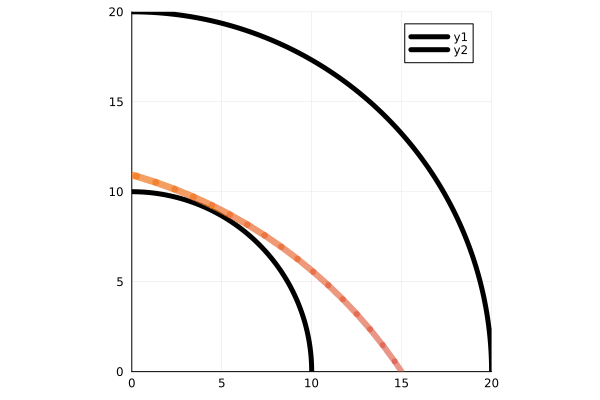

In [53]:
@userplot CirclePlot
@recipe function f(cp::CirclePlot)
    x, y, i = cp.args
    n = length(x)
    inds = circshift(1:n, 1 - i)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    x[inds], y[inds]
end

function animacja(num)
    n = 150
    t = range(-pi, π, length = n)
    y = promienie[num]*sin.(t) .+ y_wspolrzedne[num]
    x = promienie[num]*cos.(t) .+ x_wspolrzedne[num] 
    
    anim = @animate for i ∈ 1:n
        circleplot!(x, y, i)
    end
    
    @gif for i ∈ 1:n
        plot(luk_min, luk_max, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
        circleplot!(x, y, i, line_z = 1:n, cbar = false, framestyle = :zerolines,  xlim=(0,20), ylim=(0, 20))
    end every 5
end

animacja(argmin(dlugosci))

Powyższa animacja najkrótszej trasy w idealny sposób obrazuje, że wyznaczona przez nas trasa rzeczywiście w znaczący sposób przypomina prostą oraz kąty nachylenia w kolejnych elementach są stosunkowo małe co pokrywa się pierwotną wizją naszej optymalnej dla bolidu trasy.

## GENEROWANIE NAJKRÓTSZYCH TRAS

In [22]:
najkrotsze_trasy = []
promienie_najkrotszych_tras = []
czas = []

for i in 1:50
    dlugosci = []
    generowanie_tras(ograniczenie_d, ograniczenie_g)
    push!(najkrotsze_trasy, dlugosci[argmin(dlugosci)])
    push!(promienie_najkrotszych_tras, promienie[argmin(dlugosci)])
    push!(czas, dlugosci[argmin(dlugosci)]/5) #przy prędkości stałej v = 5
end

println("Średnia arytmetyczna najkrótszych długości tras: ", mean(najkrotsze_trasy))
zestawienie_najkrótszych_tras = DataFrame( DŁUGOŚĆ = najkrotsze_trasy, PROMIEŃ = promienie_najkrotszych_tras, CZAS = czas)

Średnia arytmetyczna najkrótszych długości tras: 18.983355477228503


50×3 DataFrame
 Row │ DŁUGOŚĆ  PROMIEŃ  CZAS    
     │ Any      Any      Any     
─────┼───────────────────────────
   1 │ 18.9709  42.111   3.79419
   2 │ 18.9431  30.8683  3.78862
   3 │ 18.9875  18.1418  3.7975
   4 │ 19.0352  30.4278  3.80704
   5 │ 18.9852  35.6294  3.79704
   6 │ 19.0143  44.1112  3.80286
   7 │ 18.9947  46.5193  3.79895
   8 │ 18.9848  47.1868  3.79696
   9 │ 18.9597  28.4282  3.79193
  10 │ 18.9869  18.0786  3.79738
  11 │ 18.9515  30.12    3.79031
  ⋮  │    ⋮        ⋮        ⋮
  41 │ 19.0127  27.3176  3.80255
  42 │ 19.0222  29.6025  3.80444
  43 │ 18.9433  44.945   3.78865
  44 │ 18.9603  46.6139  3.79205
  45 │ 19.0284  16.5741  3.80567
  46 │ 18.9537  40.1787  3.79074
  47 │ 18.9716  31.326   3.79431
  48 │ 18.9693  27.1999  3.79387
  49 │ 18.9552  37.5002  3.79104
  50 │ 19.0644  18.756   3.81288
                  29 rows omitted

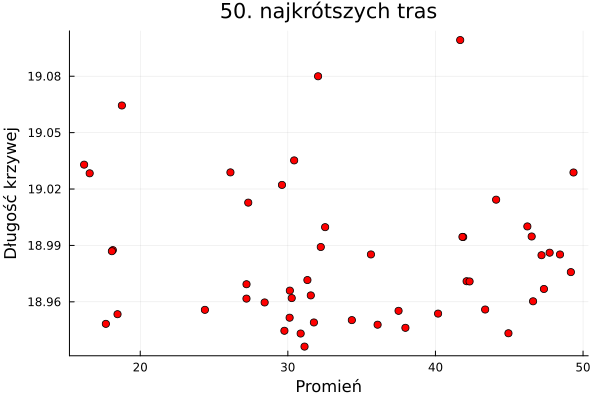

In [23]:
gr()
scatter(promienie_najkrotszych_tras, zestawienie_najkrótszych_tras.DŁUGOŚĆ, label=false, color=:red)
xlabel!("Promień")
ylabel!("Długość krzywej")
title!("50. najkrótszych tras")


Generując 50. pętli z których wyciągamy najmniejsze długości łuków oraz ich promienie możemy zbadać dodatkowo, iż trasa nie jest zależna od długości przybliżenia kołowego. Natomiast znaczącą rolę mają kąty nachylenia w kolejnych elementach trasy (im one mniejsze tym trasa będzie bliższa prostej i co za tym idzie krótsza). Na powyższym wyresie widoczna jest zależność długości krzywej od promienia co doskonale obrazuje różnice w zmiennych oraz mały zakres zmian najkrótszych tras w kolejnych pętlach. Warto jeszcze zwrócić uwagę na czas na kolejnych trasach, różnice nie są znaczące jednak na torze Formuły 1 najmniejsze dysonanse wpływają na cały bieg wyścigu i często są znaczące dla końcowego wyniku bolidu. 

## PODSUMOWANIE

Reasumując, w naszym projekcie zbadaliśmy trasy aby wyznaczyć tę jedną, stosunkowo najlepszą dla bolidu. Udało się to dzięki założeniu, że najkrótsza trasa rzeczywiście pokrywa się w znaczącym stopniu z trasą optymalną. Posługłując się czterema sposobami obliczyliśmy długości wygenerowanych losowo tras potwierdzając tym samym, że nasze obliczenia nie są błędne. Dodatkowo nasze działania zostały zobrazowane na wykresach ukazujących zarówno wygenerowane trasy jak również tę jedną, najkrótszą. Analizując wyniki jesteśmy w stanie stwierdzić, że trasy w kolejnych generowanch pętlach nachądzą na siebie wręcz sobie odpowiadają, co jest widoczne poprzez zestawienie tabelaryczne 50. najkrótszych tras z kolejnych pętli. 

Chcąc poprzeć nasz projekt opinią bieglejszej w danej kwestii osoby odsyłamy do materiału wideo: https://www.youtube.com/watch?v=KBXMan0Dafw [1:24-2:31]. Materiał ten stanowi swoiste potwierdzenie zarówno naszej tezy jak również otrzymanych wyników.